# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** 

Kristoffer Landsnes

&

Arthur Gassner (250089)

**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

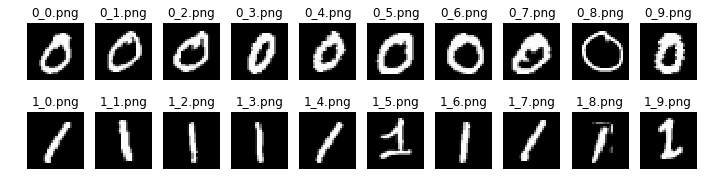

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

# 1.2 Fourier descriptors


## 1.2.1 Implementation details

We first computed the contour of the image using the `skimage.measure` library. If several were found, we use the one with the biggest amount of points, since it should correspond to the outer contour.

We can then compute the fourier descriptors of the images. The **first fourier descriptor (f0)** is **not used** to describe the image, since it is **not invariant to translations**.

In [219]:
import numpy as np
import matplotlib.pyplot as plt
import cmath 
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import skimage

from skimage import measure

In [176]:
def contour2matrix(contour, shape):
    """
    Convert contour to matrix
    """
    contour_matrix = np.zeros(shape)
    for x, y in zip(contour[:,1], contour[:,0]):
        contour_matrix[int(round(y)),int(round(x))] = 1
        
    return contour_matrix

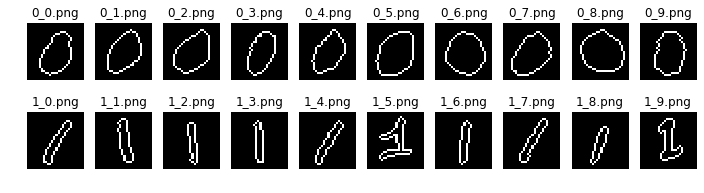

In [214]:
def get_contour(img, 
                iso_value=100):
    """
    Return the biggest contour (as a matrix) found in the img
    """
    # Find contours at a constant value of 100
    contours = measure.find_contours(img, 100)
    
    # Sort contours so that the contour with the 
    # biggest amount of points will be first
    contours.sort(key = lambda c: c.shape[0], reverse=True)
    
    contour = contours[0]
    
    return contour

### TEST RUN ###

# Display the image and plot all contours found

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    c = get_contour(im)
    ax.imshow(contour2matrix(c, im.shape), cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    c = get_contour(im)
    ax.imshow(contour2matrix(c, im.shape), cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [178]:
def compute_complex_signal(contour):
    """
    Take a contour (i.e. a Nx2 matrix with the (x,y) coordinates
    of the N points)
    Return a Nx1 matrix of successive complex points, where u = x + j*y
    """
    complex_signal = []
    for x, y in zip(contour[:,1], contour[:,0]):
        u = x + y*1j
        complex_signal.append(u)
    return complex_signal

In [199]:
def compute_fourier_descriptor(complex_signal, l):
    """
    Return the lth fourier descriptor of complex_signal
    A fourier descriptor is a complex number
    """
    N = len(complex_signal)
    
    fl = 0
    for k in range(0, N):
        uk = complex_signal[k]
        exponant = -2*cmath.pi*k*l/N*1j
        fl += uk*cmath.exp(exponant)
    return fl

In [200]:
def get_abs_fl(l, img):
    """
    l : lth of the fourier descriptor to extract
    Take a black and white img
    Return a real number, 
    representing the amplitudes of the fourier descriptor 
    """
    c = get_contour(img)
    cs = compute_complex_signal(c)
    
    return abs(compute_fourier_descriptor(cs, l))

# 1.2.2 Results

We can know compute the fourier descriptors of the pictures

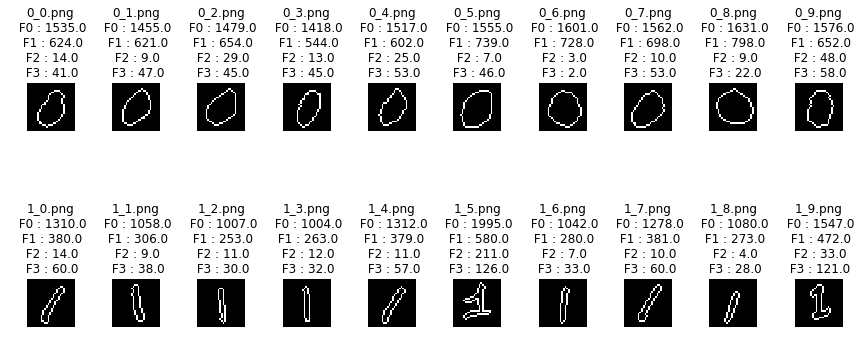

In [217]:
### SHOW DESCRIPTORS OF PICS ###

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 6))

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    c = get_contour(im)
    cs = compute_complex_signal(c)
    
    title = nm
    for l in range(0,4):
        fl = compute_fourier_descriptor(cs, l)
        title += "\n F" + str(l) + " : " + str(round(abs(fl)))

    ax.imshow(contour2matrix(c, im.shape), cmap='gray')
    ax.axis('off')
    ax.set_title(title)

for ax, im, nm in zip(axes[1], ones_im, ones_names):
    c = get_contour(im)
    cs = compute_complex_signal(c)
    
    title = nm
    for l in range(0,4):
        fl = compute_fourier_descriptor(cs, l)
        title += "\n F" + str(l) + " : " + str(round(abs(fl)))

    ax.imshow(contour2matrix(c, im.shape), cmap='gray')
    ax.axis('off')
    ax.set_title(title)
    
plt.tight_layout()

### Plotting the amplitude of f1 and f2

Plotting the amplitude of the second (f1) and third (f2) fourier descriptor allow us to see that the images cluster nicely.

We however notice one clear outlier, which corresponds to `1.5.png`. By visually inspecting this image, we notice that it is clearly different from the other 1's present in the images (i.e. it is not simply a drawn bar)

A similar comment can be made for `1_9.png`, although this one is not such a clear outlier. Again, by visually inspecting the image, we can see that it differs from the other 1's, although less severly.

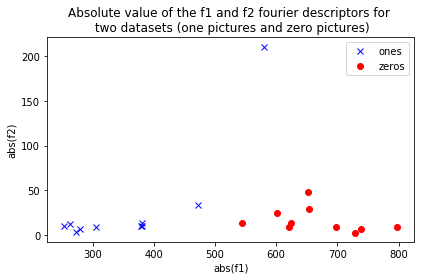

In [205]:
# PLOT THE AMPLITUDE OF (F1 AND F2)

# record ones' features
ones_features = [[],[]]    
for im in ones_im:
    for i, l in enumerate(range(1,3)):
        abs_fl = get_abs_fl(l, im)
        ones_features[i].append(abs_fl)

# record zeros' features
zeros_features = [[],[]]    
for im in zeros_im:
    for i, l in enumerate(range(1,3)):
        abs_fl = get_abs_fl(l, im)
        zeros_features[i].append(abs_fl)

# plot in 2D
plt.plot(ones_features[0], ones_features[1], 'bx')
plt.plot(zeros_features[0], zeros_features[1], 'ro')


# make things pretty
plt.xlabel("abs(f1)")
plt.ylabel("abs(f2)")
plt.legend(["ones", "zeros"])
plt.title("Absolute value of the f1 and f2 fourier descriptors for \n two datasets (one pictures and zero pictures)")

plt.tight_layout()

### Plotting the amplitude of f1, f2 and f3

Plotting the amplitude of the second (f1), third (f2) and fourth (f3) fourier descriptor allow us to see that the images cluster even more nicely than with two descriptors. This makes sense since we now have more data describing the images.

The same outliers as before (`1_5.png` and `1_9.png`) can be noticed as having a abs(f3) value higher than the other 1's. 

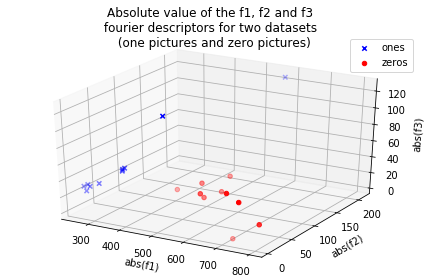

In [206]:
# PLOT THE AMPLITUDE OF (F1, F2 AND F3)

# record ones' features
ones_features = [[], [], []]    
for im in ones_im:
    for i, l in enumerate(range(1,4)):
        abs_fl = get_abs_fl(l, im)
        ones_features[i].append(abs_fl)

# record zeros' features
zeros_features = [[],[], []]    
for im in zeros_im:
    for i, l in enumerate(range(1,4)):
        abs_fl = get_abs_fl(l, im)
        zeros_features[i].append(abs_fl)

# PLOT IN 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for c, m, features in [('b', 'x', ones_features), ('r', 'o', zeros_features)]:
    xs = features[0]
    ys = features[1]
    zs = features[2]
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('abs(f1)')
ax.set_ylabel('abs(f2)')
ax.set_zlabel('abs(f3)')
ax.legend(["ones", "zeros"])
ax.set_title("Absolute value of the f1, f2 and f3 \n fourier descriptors for two datasets  \n (one pictures and zero pictures)")
fig.tight_layout()

In [227]:
## TODO

# - SHOW THAT THE STARTING POINT ONLY AFFECTS THE PHASE, NOT THE AMPLITUDE
# - SHOW THAT TRANSLATION ONLY CHANGES F0
# - SHOW THAT ROTATION ONLY CHANGE THE PHASE, NOT THE AMPLITUDE
# - SHOW THAT SCALING DOES NOT CHANGE THE RATIO OF THE AMPLITUTDE


# 1.3 Additional method(s)

# pca

# ica

# do region detection and find the one with eccentricty (or moment)

# do bounding box, and with the one with high width/height ratio

(At least 3 additional (on top of fourier) to have 6)


# 1.3a Threshold, region detection and minor axis length

We will first use a histogram to find a good threshold. We chose to use the minimum method given the shape of the histogram (two peaks). We then threshold the picture and apply region detection.

When looking at the shape of 1's and 0's, one can expect that the length of the minor axis of the region's ellipse will be greater for 0's than for ones. The ellipse in question is the ellipse that has the same normalized second central moments as the region.

We will use this to separate them.

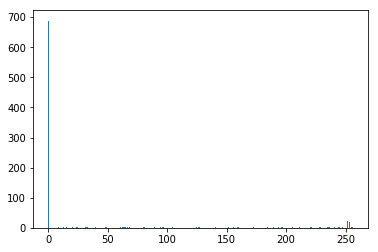

In [265]:
im = ones_im[0]

hist = plt.hist(im.ravel(), 256,[0,256])


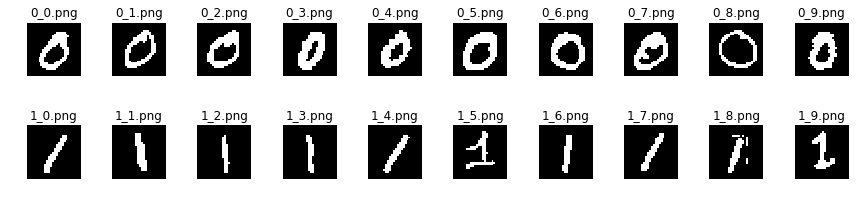

In [266]:
# Display the thresholded images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    # thresholding
    thresh = skimage.filters.threshold_minimum(im)
    binary = im > thresh
    
    ax.imshow(binary, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    # thresholding
    thresh = skimage.filters.threshold_minimum(im)
    binary = im > thresh
    
    ax.imshow(binary, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
fig.tight_layout()

In [267]:
def get_region(img):
    """
    img : RGB image
    Return the largest region found after applying minimum threshold on img and the labeled image
    """
    thresh = skimage.filters.threshold_minimum(im)
    binary = img > thresh
    
    label_img = measure.label(binary)
    regions = measure.regionprops(label_img)
    
    regions.sort(key = lambda c: c.area, reverse=True)
    
    return regions[0], label_img

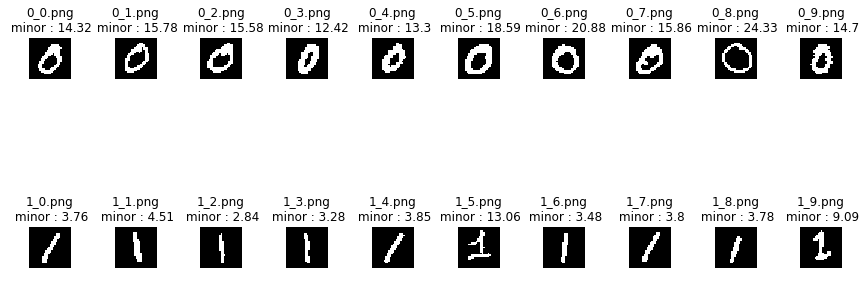

In [281]:
# Display detected regions
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 6))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    # region finding
    r, labeled_im = get_region(im)
    a = np.array(labeled_im)
    a[a!=r.label] = 0
    
    ax.imshow(a, cmap='gray')
    ax.axis('off')
    
    title = nm + "\n minor : " + str(round(r.minor_axis_length, 2))
    ax.set_title(title)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    # region finding
    r, labeled_im = get_region(im)
    a = np.array(labeled_im)
    a[a!=r.label] = 0
    
    ax.imshow(a, cmap='gray')
    ax.axis('off')
    
    title = nm + "\n minor : " + str(round(r.minor_axis_length, 2))
    ax.set_title(title)
fig.tight_layout()

# 1.3a Results of threshold, region detection and minor axis length

As we can see below, and as expected, using the minor axis length as a discriminant works rather well. 

However, we still have two outliers in the *ones dataset* : `1_5.png` and `1_9.png`. This makes sense by visually inspecting since they have a vertical bar that the other datapoint from the *ones* dataset do not have.


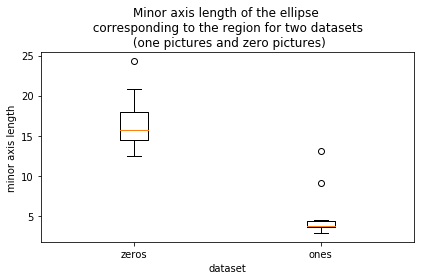

In [312]:
# PLOT THE MINOR AXIS LENGTH

# record ones' minor axis length
ones_minors = []
for im in ones_im:    
    r, _ = get_region(im)
    minor_length = r.minor_axis_length 
    ones_minors.append(minor_length)

# record minor axis length
zeros_minors = []    
for im in zeros_im:
    r, _ = get_region(im)
    minor_length = r.minor_axis_length 
    zeros_minors.append(minor_length)

# plot in 2D
plt.boxplot([zeros_minors, ones_minors])

# make things pretty
plt.xticks([1,2], ["zeros", "ones"])
plt.xlabel("dataset")
plt.ylabel("minor axis length")
plt.title("Minor axis length of the ellipse \n corresponding to the region for two datasets \n (one pictures and zero pictures)")

plt.tight_layout()

# 1.3b Threshold, region detection and holes

We will first use a histogram to find a good threshold. We chose to use the minimum method given the shape of the histogram (two peaks). We then threshold the picture and apply region detection.

When looking at the shape of 1's and 0's, one can expect the ratio (unfilled region)/(filled region) of 1's to be greater than the ones of 0's. 

We will use this to separate them.

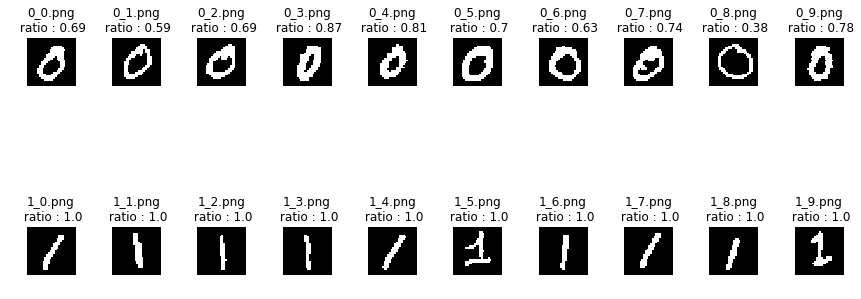

In [321]:
# Display detected regions
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 6))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    # region finding
    r, labeled_im = get_region(im)
    a = np.array(labeled_im)
    a[a!=r.label] = 0
    
    ax.imshow(a, cmap='gray')
    ax.axis('off')
    
    ratio = r.area/r.filled_area
    
    title = nm + "\n ratio : " + str(round(ratio, 2))
    ax.set_title(title)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    # region finding
    r, labeled_im = get_region(im)
    a = np.array(labeled_im)
    a[a!=r.label] = 0
    
    ax.imshow(a, cmap='gray')
    ax.axis('off')
    
    ratio = r.area/r.filled_area
    
    title = nm + "\n ratio : " + str(round(ratio, 2))
    ax.set_title(title)
fig.tight_layout()

# 1.3a Results of threshold, region detection and minor axis length

As we can see below, and as expected, using the unfilled/filled area ratio as a discriminant works rather well. 

We can notice that the two usual outliers (, we still have two outliers in the *ones dataset* : `1_5.png` and `1_9.png`. This makes sense by visually inspecting since they have a vertical bar that the other datapoint from the *ones* dataset do not have.


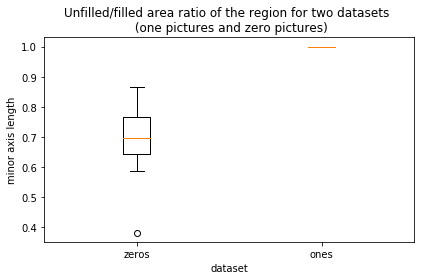

In [322]:
# PLOT THE UNFILLED/FILLED AREA RATIO

# record ones' UNFILLED/FILLED AREA RATIO
ones_ratios = []
for im in ones_im:    
    r, _ = get_region(im)
    ones_ratios.append(r.area/r.filled_area)

# record UNFILLED/FILLED AREA RATIO
zeros_ratios = []    
for im in zeros_im:
    r, _ = get_region(im)
    zeros_ratios.append(r.area/r.filled_area)

# plot in 2D
plt.boxplot([zeros_ratios, ones_ratios])

# make things pretty
plt.xticks([1,2], ["zeros", "ones"])
plt.xlabel("dataset")
plt.ylabel("minor axis length")
plt.title("Unfilled/filled area ratio of the region for two datasets \n (one pictures and zero pictures)")

plt.tight_layout()